<font size="7"><span style="color:green">Librerías

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import AdaBoostClassifier 


import xgboost
    # NOTA
    # xgboost.XGBRFClassifier En cada secuencia tiene un RandomForest
    # xgboost.XGBClassifier sin RandomForest

# ------------------

# Pipeline
from sklearn.pipeline import Pipeline
    # NOTA
    # Hay que poner las etiquetas automáticamente. El otro es 'from sklearn.pipeline import make_pipeline'

# ------------------

# Métricas de validación
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
# ------------------

# GridSearch
from sklearn.model_selection import GridSearchCV

# ------------------

# Balanceo
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# ------------------

# Otras
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [2]:
# LECTURA CSV
vinos = pd.read_csv('data/winequalityN.csv')

In [3]:
# SEED
seed=33

In [4]:
# Hacemos otro df con sólo los vinos blancos
blanco=vinos[vinos['type']=='white'].reset_index()
blanco = blanco.drop(['index', 'type'], axis=1)

In [5]:
# Nos deshacemos de los valores nulos

print("Columnas pre drop:", len(blanco))

blanco = blanco.dropna()

print("Columnas post drop:", len(blanco))

Columnas pre drop: 4898
Columnas post drop: 4870


In [6]:
# Cambiamos la variable Target para que sea solo entre 'aptos=1' y 'no aptos=0'
my_dict={3:0, 4:0, 5:0,
        6:1, 7:1, 8:1, 9:1}
blanco['apto']= blanco['quality'].map(my_dict)
blanco = blanco.drop(['quality'], axis=1)

Value Counts  1    0.665298
0    0.334702
Name: apto, dtype: float64


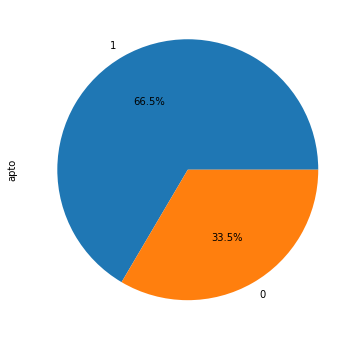

In [7]:
#  Ver el balance de los datos
print('Value Counts ', blanco['apto'].value_counts(normalize=True))
plt.figure(figsize=(10,6))
blanco['apto'].value_counts().plot.pie(autopct="%.1f%%");

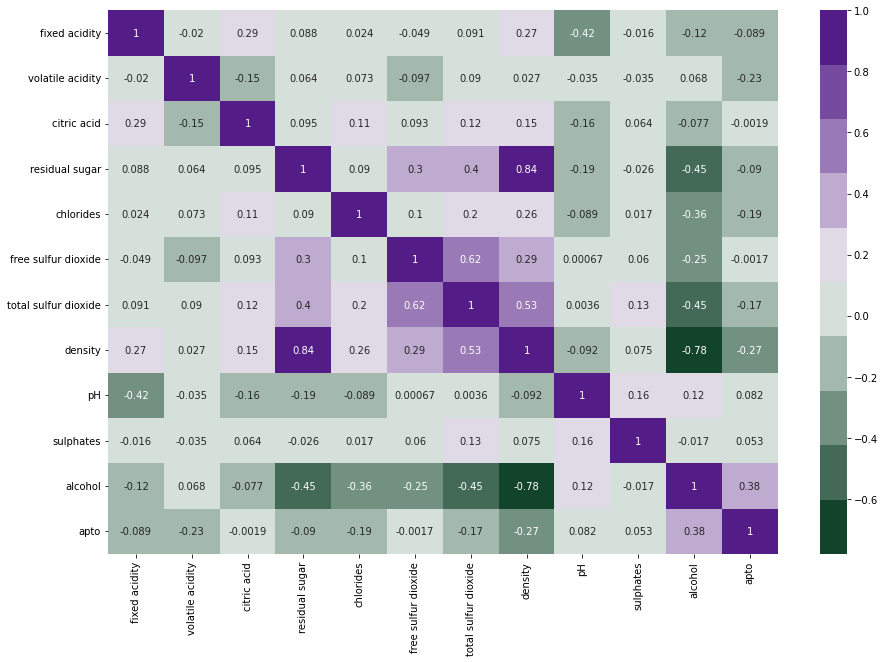

In [8]:
# Heatmap para ver la correlación de los datos
plt.figure(figsize=(15,10))
sns.heatmap(blanco.corr(),cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10), annot=True);

In [9]:
# Quitamos la variable 'densidad', ya que depende del azucar y del alcohol.

# He probado a quitar 'free sulfur dioxide', porque depende de 'total sulfur dioxide', pero se ve que hay algo más que influye en ella,
# y el modelo predice mejor si la dejamos

X = blanco[['fixed acidity', 'volatile acidity', 'citric acid','residual sugar',
       'chlorides', 'free sulfur dioxide','total sulfur dioxide',
       'pH', 'sulphates', 'alcohol']]
y = blanco['apto']

In [10]:
# Balanceo ROS
ros = RandomOverSampler(random_state=seed)
X_ros, y_ros = ros.fit_resample(X, y)


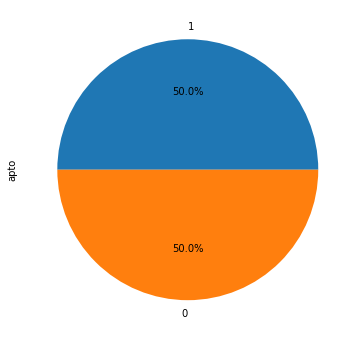

In [11]:
# Vemos el nuevo balance de los datos.
plt.figure(figsize=(10,6))
y_ros.value_counts().plot.pie(autopct="%.1f%%");


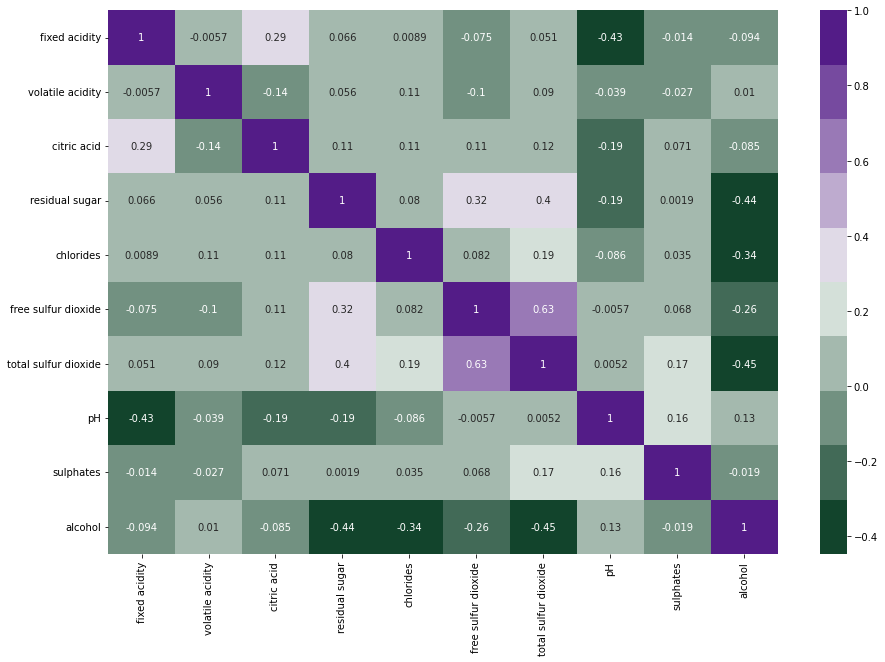

In [120]:
plt.figure(figsize=(15,10))
sns.heatmap(X_ros.corr(),cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10), annot=True);

In [12]:
# Entrenamiento tras el balanceo. Al agregar el stratify he ganado otro 1%
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2,stratify=y_ros, random_state=seed)

In [13]:
# Pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('kbest', SelectKBest()),
                       ('classifier', LogisticRegression(random_state=seed))])

Best model. Best Score 0.8624614197530865 
 --------------------------------------------------
Best model. Best Params {'classifier': GradientBoostingClassifier(learning_rate=0.25, max_depth=6, n_estimators=300), 'classifier__learning_rate': 0.25, 'classifier__max_depth': 6, 'classifier__n_estimators': 300, 'kbest__k': 10} 
 --------------------------------------------------
Accuracy Score 0.9228395061728395 
 --------------------------------------------------
Confusion Matrix 
 [[620  28]
 [ 72 576]] 
 --------------------------------------------------


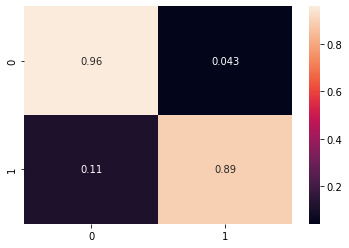

In [14]:
# GridSearch. Dejo solo el GradientBoostingClassifier con 'max_depth=5' porque es el que mejor resultado me ha dado

# svm_params = {'kbest__k': [5,7,8,9],
#               'classifier': [SVC()],
#               'classifier__C': [0.5,0.8,1],
#               'classifier__kernel': ['linear','rbf','sigmoid']
# }

# log_params = {'kbest__k': [5,7,8,9],
#               'classifier': [LogisticRegression()],
#               'classifier__penalty': ['l1','l2'],
#               'classifier__C': np.logspace(0,2,5)
# }

# knn_params = {'kbest__k': [5,7,8,9],
#               'classifier': [KNeighborsClassifier()],
#               'classifier__n_neighbors': [5,10,12,17,20],
#               'classifier__weights': ['uniform','distance']
# }

# rf_params = {'kbest__k': [5,7,8,9],
#               'classifier': [RandomForestClassifier()],
#               'classifier__n_estimators': [50,100,150],
#               'classifier__max_depth': [2,3,4,5,6,7],
#               'classifier__min_samples_leaf': [1,3,5]
# }

gb_params = {'kbest__k': [8,9,10],
              'classifier': [GradientBoostingClassifier()],
            #   'classifier__max_depth': [2,3,4,5,6],
              'classifier__max_depth': [6,7],
              'classifier__n_estimators': [200,250,300,450],
              'classifier__learning_rate': [0.1,0.15,0.2,0.25,0.3,0.35]
}

# ada_params = {'kbest__k': [7,8,9],
#               'classifier': [AdaBoostClassifier()],
#               'classifier__n_estimators': [150,200,300,350],
#               'classifier__learning_rate': [0.3,0.5,0.7,1]
# }

# xgb_params = {'kbest__k': [7,8,9],
#               'classifier': [xgboost.XGBRFClassifier()],
#               'classifier__n_estimators': [175,200,225],
#               'classifier__learning_rate': [0.01,0.02,0.03,0.05]
# }

# search_space = [svm_params, log_params, knn_params, rf_params, gb_params, ada_params, xgb_params]
search_space = [gb_params]

clf = GridSearchCV(estimator=pipe, param_grid=search_space, cv=3, n_jobs=-1)
best_model = clf.fit(X_train, y_train)

y_pred = best_model.best_estimator_.predict(X_test)

print('Best model. Best Score', best_model.best_score_, '\n','-'*50)
print('Best model. Best Params', best_model.best_params_, '\n','-'*50)
print('Accuracy Score', accuracy_score(y_test, y_pred), '\n','-'*50)
print('Confusion Matrix \n', confusion_matrix(y_test,y_pred), '\n','-'*50)
sns.heatmap(confusion_matrix(y_test,y_pred, normalize='true'), annot=True);

In [29]:
print(best_model.best_estimator_.named_steps)

{'scaler': StandardScaler(), 'kbest': SelectKBest(), 'classifier': GradientBoostingClassifier(learning_rate=0.25, max_depth=6, n_estimators=300)}


In [34]:
best_model.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('kbest', SelectKBest()),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.25, max_depth=6,
                                            n_estimators=300))])

In [33]:
print(best_model.best_estimator_.named_steps["classifier"].feature_importances_)


[0.06227818 0.14750031 0.07143194 0.08386521 0.07553985 0.11204549
 0.08663133 0.07022241 0.05405053 0.23643474]


Feature: 0, Score: 0.06228
Feature: 1, Score: 0.14750
Feature: 2, Score: 0.07143
Feature: 3, Score: 0.08387
Feature: 4, Score: 0.07554
Feature: 5, Score: 0.11205
Feature: 6, Score: 0.08663
Feature: 7, Score: 0.07022
Feature: 8, Score: 0.05405
Feature: 9, Score: 0.23643


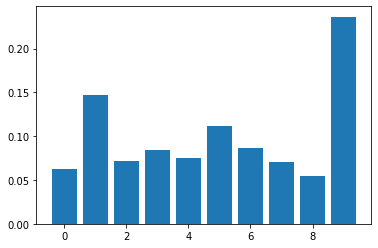

In [35]:
# NO TOCAR
from sklearn.datasets import make_classification

from matplotlib import pyplot
importance = best_model.best_estimator_.named_steps["classifier"].feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [36]:
# NO TOCAR
names=X.columns

scores = sorted(zip(map(lambda x: round(x, 4), importance), names), reverse=True)
pd.DataFrame(scores, columns=['Score', 'Feature'])

,Score,Feature
0,0.2364,alcohol
1,0.1475,volatile acidity
2,0.1120,free sulfur dioxide
3,0.0866,total sulfur dioxide
4,0.0839,residual sugar
5,0.0755,chlorides
6,0.0714,citric acid
7,0.0702,pH
8,0.0623,fixed acidity
9,0.0541,sulphates


<AxesSubplot:>

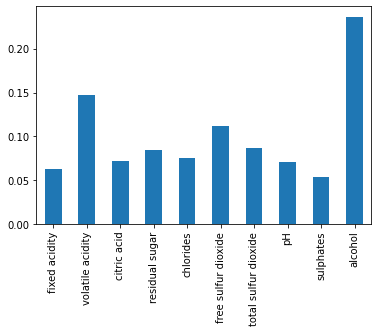

In [73]:
# X = pd.read_csv("titanic_train.csv")
# X = X[['Pclass', 'Age', 'Fare', 'Parch', 'SibSp', 'Survived']].dropna()
# y = X.pop('Survived')

# model = RandomForestClassifier()
# model.fit(X, y)

(pd.Series(importance, index=names)
#    .nlargest(4)
   .plot(kind='bar'))  

<AxesSubplot:>

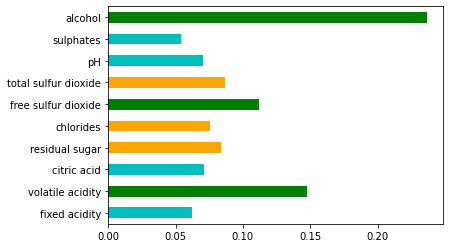

In [93]:
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'g','b','orange', 'c']
# colors = ['c', 'r', 'c', 'orange', 'orange', 'r', 'orange','c','c', 'r']
# colors = ['c', 'r', 'c', 'm', 'm', 'r', 'm','c','c', 'r']
colors = ['c', 'g', 'c', 'orange', 'orange', 'g', 'orange','c','c', 'g']

(pd.Series(importance, index=names)
#    .nlargest(4)
   .plot(kind='barh',color=colors))  


<AxesSubplot:>

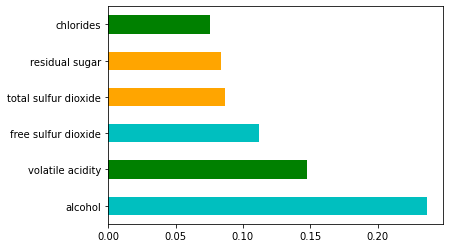

In [94]:
(pd.Series(importance, index=names)
   .nlargest(6)
   .plot(kind='barh',color=colors))  

In [37]:
X_test

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol
1906,9.2,0.270,0.34,10.5,0.043,49.0,228.0,3.04,0.41,10.4
5538,7.2,0.160,0.35,1.2,0.031,27.0,84.0,3.33,0.34,9.9
1126,6.9,0.320,0.17,7.6,0.042,69.0,219.0,3.13,0.40,8.9
6265,8.0,0.280,0.42,7.1,0.045,41.0,169.0,3.17,0.43,10.6
1693,6.8,0.270,0.32,1.5,0.044,19.0,142.0,3.10,0.43,9.9
...,...,...,...,...,...,...,...,...,...,...
4378,5.9,0.290,0.16,7.9,0.044,48.0,197.0,3.21,0.36,9.4
139,6.3,0.255,0.37,1.1,0.040,37.0,114.0,3.00,0.39,10.9
6192,5.9,0.190,0.37,0.8,0.027,3.0,21.0,3.09,0.31,10.8
2048,6.6,0.230,0.27,5.6,0.043,43.0,164.0,3.27,0.76,9.5


In [44]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1906 to 5349
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1296 non-null   float64
 1   volatile acidity      1296 non-null   float64
 2   citric acid           1296 non-null   float64
 3   residual sugar        1296 non-null   float64
 4   chlorides             1296 non-null   float64
 5   free sulfur dioxide   1296 non-null   float64
 6   total sulfur dioxide  1296 non-null   float64
 7   pH                    1296 non-null   float64
 8   sulphates             1296 non-null   float64
 9   alcohol               1296 non-null   float64
dtypes: float64(10)
memory usage: 111.4 KB


In [112]:
predict_df=pd.DataFrame(best_model.predict(X_test))
# round para que decida solo si es 0 o 1 

In [113]:
predict_df

,0
0,1
1,0
2,0
3,0
4,0
...,...
1291,0
1292,1
1293,0
1294,0


Value Counts  0    0.533951
1    0.466049
dtype: float64


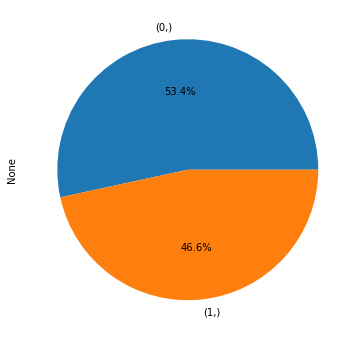

In [115]:
print('Value Counts ', predict_df.value_counts(normalize=True))
plt.figure(figsize=(10,6))
predict_df.value_counts().plot.pie(autopct="%.1f%%");